# Capstone Project Part 6: Text Tokenizing

**Authur:** Kate Meredith 

**Date:** September-November 2022

**Notebook #**: 6 of

## Background

**Source:** Data was collected from [CoffeeReview.com](https://www.coffeereview.com/). See prior notebooks for details on scraping, cleaning and compilation. This notebook focuses on tokenizing the review text.

**Goal:** Experiment with text tokenizing methods to compare baseline effectiveness across the tested tools.

In [288]:
#Importing libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp

### References

- Used this [article](https://stackoverflow.com/questions/37080612/pandas-dataframe-filter-regex) for searching for specific text in columns
- Used BrainStation notebook on working with text
- Referenced this [article](https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b) for strategy on how to stratefy train/val/test split where target is a continuous variable
- Referenced this [article](https://stackoverflow.com/questions/61158963/how-to-sort-the-result-by-pandas-value-counts) to see value_counts sorted by column value instead of frequency

### Importing and previewing data

In [185]:
coffee = pd.read_csv('coffee.csv')

In [186]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6557 entries, 0 to 6556
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   coffee_name    6557 non-null   object 
 1   roaster_name   6557 non-null   object 
 2   month          6557 non-null   int64  
 3   year           6557 non-null   int64  
 4   bean_agtron    6557 non-null   int64  
 5   ground_agtron  6557 non-null   int64  
 6   aroma          6557 non-null   int64  
 7   acidity        6557 non-null   int64  
 8   body           6557 non-null   int64  
 9   flavor         6557 non-null   int64  
 10  aftertaste     6557 non-null   int64  
 11  roaster_lat    6557 non-null   float64
 12  roaster_lon    6557 non-null   float64
 13  origin_lat     6557 non-null   float64
 14  origin_lon     6557 non-null   float64
 15  p1             6557 non-null   object 
 16  p2             6557 non-null   object 
 17  p3             6557 non-null   object 
 18  overall_

In [187]:
coffee.shape

(6557, 19)

In [188]:
coffee.head()

,coffee_name,roaster_name,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,p1,p2,p3,overall_score
0,Colombia Cerro Azul Enano,Equator Coffees,10,2022,60,77,9,9,9,9,8,37.973535,-122.531087,4.099917,-72.908813,Blind Assessment: Elegantly fruit- and cocoa-t...,Notes: Produced at Finca Cerro Azul (also owne...,The Bottom Line: This rare Enano (dwarf Geish...,94
1,Peru Incahuasi,Press Coffee,10,2022,58,78,9,9,9,9,8,33.448437,-112.074141,-6.869970,-75.045851,"Blind Assessment: Gently fruit-toned, integrat...",Notes: Produced at Incahuasi Farm from trees o...,The Bottom Line: Laden with tropical fruit not...,94
2,Colombia Aponte’s Guardians,Press Coffee,10,2022,59,77,9,9,8,9,8,33.448437,-112.074141,4.099917,-72.908813,"Blind Assessment: Richly sweet, spice-toned. L...",Notes: Produced at Aponte Farm from an undiscl...,"The Bottom Line: A balanced, inviting washed C...",93
3,Nicaragua Flor de Dalia Natural,Equator Coffees,10,2022,62,78,8,8,9,9,8,37.973535,-122.531087,12.609016,-85.293691,"Blind Assessment: Gently fruit-forward, sweetl...",Notes: Produced by smallholding members of the...,"The Bottom Line: A refreshing, very sweet natu...",92
4,Ethiopia Bench Maji Geisha G1 Natural,Taster's Coffee,10,2022,65,81,9,9,8,9,8,25.072134,121.679919,10.211670,38.652120,"Blind Assessment: Gently sweet-tart, floral-to...",Notes: Produced from trees of the admired bota...,The Bottom Line: A quietly confident natural-p...,93


In [189]:
coffee.describe()

,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,overall_score
count,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000
mean,6.642062,2013.102181,52.229983,67.668598,8.360988,7.904224,8.086472,8.361598,7.795638,37.027419,-64.412448,10.198811,-12.161417,90.873723
std,3.437202,6.719059,8.411739,12.936090,0.927393,1.023060,0.871203,1.065692,0.874365,9.504209,81.708964,12.709097,68.848718,4.089739
min,1.000000,1997.000000,11.000000,12.000000,2.000000,1.000000,4.000000,1.000000,2.000000,-37.824425,-159.582761,-30.292848,-155.428370,60.000000
25%,4.000000,2008.000000,48.000000,60.000000,8.000000,8.000000,8.000000,8.000000,7.000000,32.840162,-117.423510,1.441968,-79.366697,90.000000
50%,7.000000,2014.000000,54.000000,71.000000,9.000000,8.000000,8.000000,9.000000,8.000000,39.049011,-89.383761,10.211670,7.540121,92.000000
75%,10.000000,2019.000000,58.000000,77.000000,9.000000,9.000000,9.000000,9.000000,8.000000,43.074761,-72.815099,13.800038,38.652120,93.000000
max,12.000000,2022.000000,91.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,64.837845,152.952215,52.380033,153.125616,98.000000


### Preprocessing

Before we create our X and y, there are some repeated words that appear in the `p1`, `p2`, and `p3` paragraphs as headers. In most reviews, these paragrapsh correspond to:

- p1: Blind Assessment
- p2: Notes
- p3: The Bottom Line OR Who Should Drink it

We'll first check to see if these paragraphs do contain the information we expect.

Checking the composition of paragraphs:

In [190]:
#see how many of p1 paragraphs reference which type of information
len(coffee.loc[coffee['p1'].str.contains(r'(Blind Assessment).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_11910/1218255241.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p1'].str.contains(r'(Blind Assessment).*')])


6557

In [191]:
#see how many of p2 paragraphs reference which type of information
len(coffee.loc[coffee['p2'].str.contains(r'(Notes).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_11910/3921903414.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p2'].str.contains(r'(Notes).*')])


6557

In [192]:
#see how many of p3 paragraphs reference which type of information
len(coffee.loc[coffee['p3'].str.contains(r'(The Bottom).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_11910/984657743.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p3'].str.contains(r'(The Bottom).*')])


2728

In [193]:
#see how many of p3 paragraphs reference which type of information
len(coffee.loc[coffee['p3'].str.contains(r'(Who Should).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_11910/2101417195.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p3'].str.contains(r'(Who Should).*')])


3777

As expected, paragraphs 1 and 2 contain consistent data, paragraph 3 is split. We'll remove "Blind Assessment", "The Bottom Line", "Who Should Drink it" and "Notes" from our bag of words as they appear in every review and therefore won't be useful in distinguishing content.

Getting rid of repeat words:

In [194]:
#splitting out paragraph review score labels
coffee[['ba','p1']] = coffee['p1'].str.split(":", n=1, expand=True)

In [195]:
#splitting out paragraph review score labels
coffee[['N','p2']] = coffee['p2'].str.split(":", n=1, expand=True)

In [196]:
#splitting out paragraph review score labels
coffee[['tbl','p3']] = coffee['p3'].str.split(":", n=1, expand=True)

In [197]:
#drop unneeded holding columns
coffee.drop(['ba', 'N', 'tbl'], axis=1, inplace=True)

In [198]:
#checking for nan
coffee.isna().sum()

coffee_name      0
roaster_name     0
month            0
year             0
bean_agtron      0
ground_agtron    0
aroma            0
acidity          0
body             0
flavor           0
aftertaste       0
roaster_lat      0
roaster_lon      0
origin_lat       0
origin_lon       0
p1               0
p2               0
p3               3
overall_score    0
dtype: int64

In [199]:
#drop rows missing value in overall_score column 
coffee.dropna(subset = ['p3'], inplace=True)

In [200]:
len(coffee)

6554

### Creating X and y

To evaluate how effective the tokenizing methods are, we'll create our X and y data.

y or target = `overall_score`
X = remaining data, but to tokenize we'll break work with `p1`,`p2`, and `p3` one at a time.

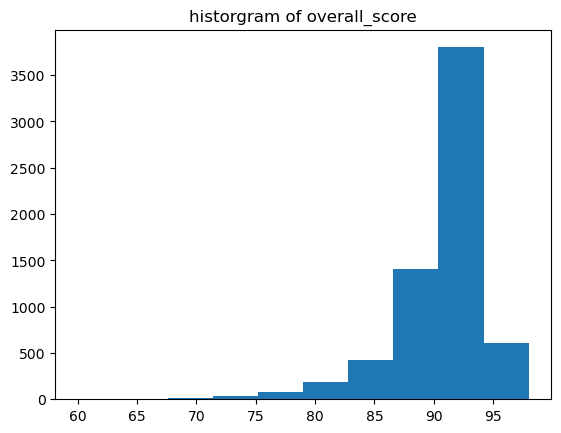

In [201]:
#plot y distribution
plt.figure()
plt.hist(coffee['overall_score'])
plt.title('historgram of overall_score')
plt.show()

Given that we can't simply stratefy our train, validation and test splits on a continuous target variable, adding a categorical value corresponding to `overall_score`. This allows train, val, test to be stratefied, allowing for even distribution of values for training, validation and testing.

In [202]:
score_mapper = {range(0,70):'one', range(70,80):'two', range(80,90):'three', range(90,95):'four', range(95,101):'five'}

In [203]:
coffee['overall_cat'] = coffee['overall_score'].replace(score_mapper)

In [204]:
coffee['overall_cat'].unique()

array(['four', 'five', 'three', 'two', 'one'], dtype=object)

In [205]:
#verifying splits appear accurate
coffee[['overall_score', 'overall_cat']].sample(20)

,overall_score,overall_cat
1448,94,four
7,94,four
171,94,four
763,94,four
6050,82,three
3336,91,four
3340,92,four
5235,87,three
859,94,four
5047,89,three


Creating X and y:

In [206]:
X = coffee.drop(['overall_score', 'overall_cat'], axis = 1)

In [207]:
X.shape

(6554, 18)

In [208]:
y = coffee[['overall_score','overall_cat']]

In [209]:
y.shape

(6554, 2)

Creating train, validation and testing splits:

In [210]:
y['overall_cat']

0        four
1        four
2        four
3        four
4        four
        ...  
6552      two
6553      two
6554     four
6555    three
6556    three
Name: overall_cat, Length: 6554, dtype: object

In [211]:
#create train/test split, using 20% given dataset size

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y['overall_cat'], test_size=0.2)

In [216]:
#create train/validate split, using 20% given dataset size

X_remain, X_val, y_remain, y_val = train_test_split(X_train, y_train, stratify = y_train['overall_cat'], test_size=0.2)

Below, verifying the shape of our new remain, validation and test splits.

In [217]:
X_train.shape

(5243, 18)

In [218]:
X_remain.shape

(4194, 18)

In [219]:
X_val.shape

(1049, 18)

In [220]:
X_test.shape

(1311, 18)

In [221]:
y_train.shape

(5243, 2)

In [222]:
y_remain.shape

(4194, 2)

In [223]:
y_val.shape

(1049, 2)

In [224]:
y_test.shape

(1311, 2)

Do my train, val, test splits have similar distributions?

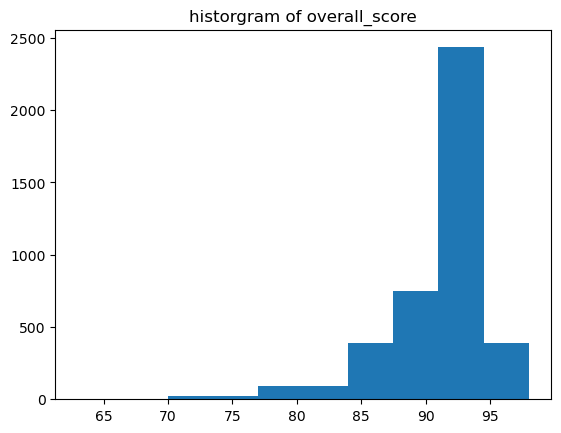

In [225]:
#plot y val distribution
plt.figure()
plt.hist(y_remain['overall_score'])
plt.title('historgram of overall_score')
plt.show()

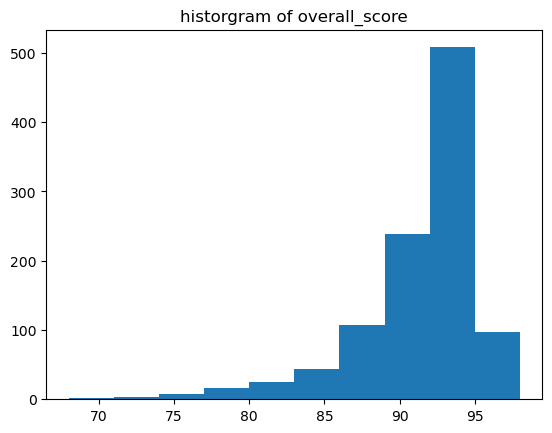

In [226]:
#plot y val distribution
plt.figure()
plt.hist(y_val['overall_score'])
plt.title('historgram of overall_score')
plt.show()

The test group looks a bit different but each group does have the range of values with somewhat similar distributions.

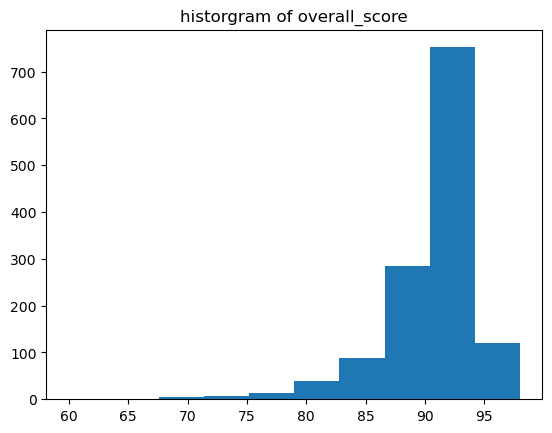

In [227]:
#plot y val distribution
plt.figure()
plt.hist(y_test['overall_score'])
plt.title('historgram of overall_score')
plt.show()

Now that we have evenly distributed splits, we'll drop the categorical column `overall_cat` so that we are just working with our continous targe `overall_score`.

In [231]:
y_train.drop(['overall_cat'], axis = 1, inplace=True)

In [232]:
y_remain.drop(['overall_cat'], axis = 1, inplace=True)

In [233]:
y_val.drop(['overall_cat'], axis = 1, inplace=True)

In [234]:
y_test.drop(['overall_cat'], axis = 1, inplace=True)

Verifying dropped correct column:

In [236]:
y_train.head()

,overall_score
1295,96
1900,94
3854,95
337,94
1073,94


In [237]:
y_remain.head()

,overall_score
464,93
1641,93
6113,90
3601,94
2766,89


In [238]:
y_val.head()

,overall_score
132,94
3277,91
1927,92
6315,85
5140,93


In [239]:
y_test.head()

,overall_score
6352,78
5137,90
4425,91
861,93
992,92


### Bag of Words with CountVectorizer()

`p1` Creating bag of words and graphing most popular:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


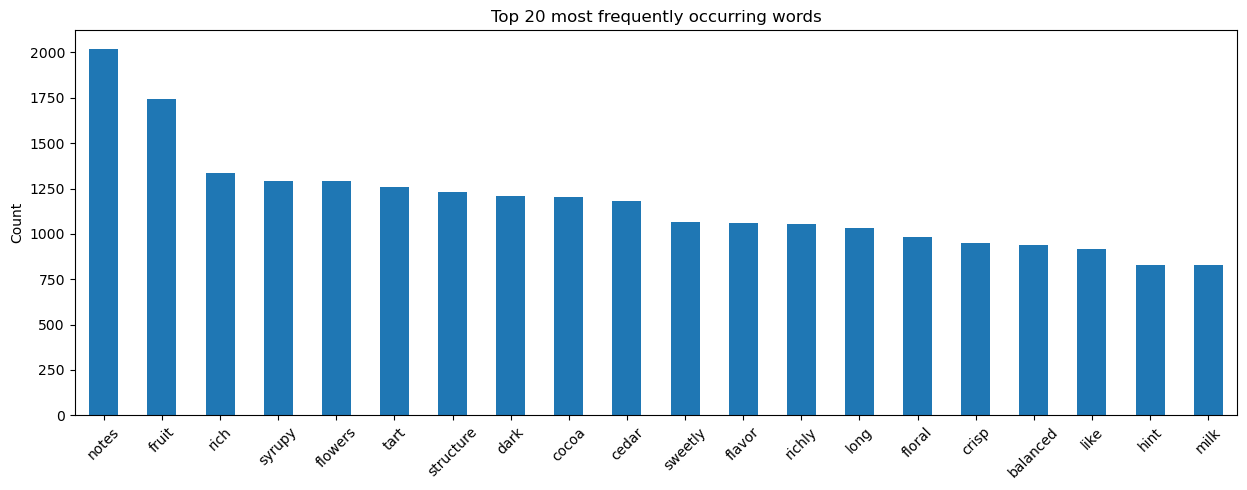

In [240]:
# 1. Instantiate 
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=5, max_features=500, max_df=2000)

# 2. Fit 
bagofwords_p1.fit(X_remain["p1"])

# 3. Transform
p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

#the following looks at the 20 most popular words from paragraph 1

word_counts = pd.DataFrame(
    {"counts": p1_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p1.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Looking at the most popular words:

In [241]:
bagofwords_p1.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['89',
 '90',
 '91',
 '92',
 'acid',
 'acidy',
 'admired',
 'aftertaste',
 'agave',
 'almond',
 'amber',
 'amplified',
 'anise',
 'apple',
 'apricot',
 'aromatic',
 'aromatically',
 'aromatics',
 'astringency',
 'astringent',
 'attractive',
 'authority',
 'b70',
 'backgrounded',
 'baker',
 'baking',
 'balance',
 'balanced',
 'banana',
 'barrel',
 'bean',
 'bergamot',
 'berries',
 'berry',
 'best',
 'big',
 'bing',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blackberry',
 'blend',
 'blood',
 'blooming',
 'blossom',
 'blueberry',
 'bodied',
 'body',
 'brandy',
 'brazil',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brisk',
 'brittle',
 'brown',
 'buoyant',
 'burned',
 'butter',
 'butterscotch',
 'buttery',
 'cacao',
 'candied',
 'candy',
 'cane',
 'cappuccino',
 'capsule',
 'caramel',
 'caramelly',
 'carbon',
 'cardamom',
 'carob',
 'carries',
 'carry',
 'carrying',
 'cashew',
 'cedar',
 'cedary',
 'centered',
 'centers',
 'character',
 'charred',
 'cherry',
 'cherr

In [242]:
#checking how many words there are
len(bagofwords_p1.get_feature_names())

500

In [243]:
# 1. Instantiate the model
p1_model = LinearRegression()

# 2. Fit the model
p1_model.fit(p1_remain_transform, y_remain)

LinearRegression()

In [244]:
# 3. Scoring the training model
print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.7897119456582152
The R2 score for p1 CountVectorizer validation data is: 0.7390051641796078


`p2` Creating first bag of words with CountVectorizer and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


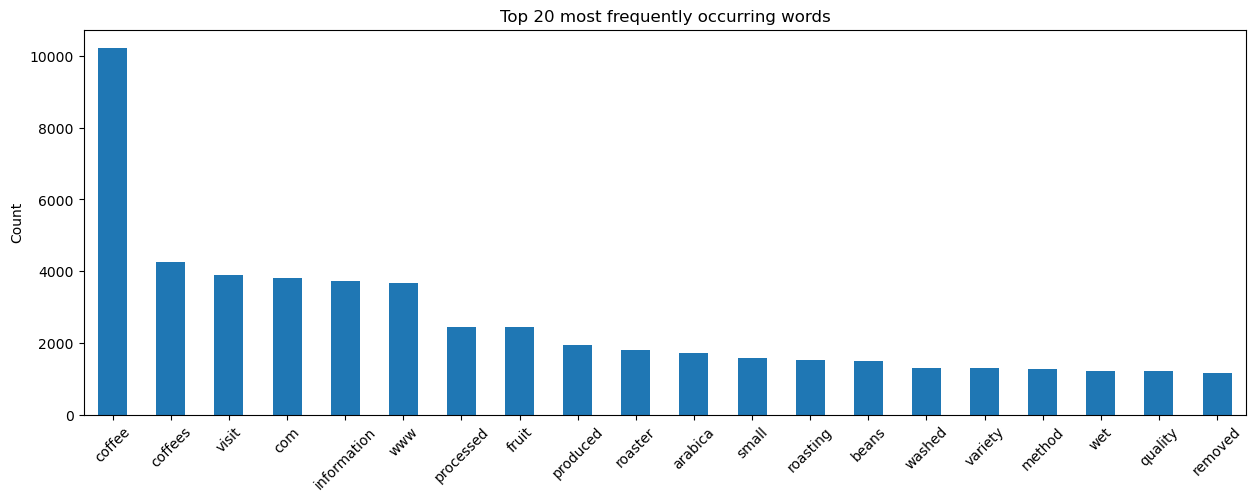

In [245]:
# 1. Instantiate 
bagofwords_p2 = CountVectorizer(stop_words='english', min_df=5, max_features=1000, max_df=4000)

# 2. Fit 
bagofwords_p2.fit(X_remain["p2"])

# 3. Transform
p2_remain_transform = bagofwords_p2.transform(X_remain["p2"])
p2_val_transform = bagofwords_p2.transform(X_val["p2"])
p2_test_transform = bagofwords_p2.transform(X_test["p2"])

#the following looks at the 20 most popular words from paragraph 2

word_counts = pd.DataFrame(
    {"counts": p2_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p2.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [246]:
bagofwords_p2.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '0245',
 '0626',
 '0983',
 '0998',
 '10',
 '100',
 '11',
 '12',
 '1282',
 '1707',
 '1990',
 '2003',
 '2004',
 '2005',
 '2007',
 '2009',
 '2010',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '206',
 '2154',
 '227',
 '2339',
 '256',
 '28',
 '2824',
 '30',
 '303',
 '322',
 '34',
 '376',
 '388',
 '400',
 '406',
 '433',
 '444',
 '454',
 '455',
 '4627',
 '4artszerodefectcoffees',
 '500',
 '503',
 '510',
 '528',
 '5282',
 '540',
 '551',
 '553',
 '579',
 '603',
 '608',
 '619',
 '6228',
 '624',
 '6505',
 '678',
 '7338',
 '745',
 '749876',
 '751',
 '763',
 '7687',
 '800',
 '808',
 '8134',
 '836',
 '8400',
 '858',
 '866',
 '877',
 '879',
 '886',
 '888',
 '894',
 '916',
 'aa',
 'acidity',
 'acidy',
 'active',
 'addition',
 'adhere',
 'adhering',
 'admired',
 'africa',
 'agencies',
 'agitate',
 'agricultural',
 'aid',
 'aimed',
 'aims',
 'air',
 'allegro',
 'alliance',
 'allowed',
 'amavida',
 'america',
 'american',
 'anaerobic',
 'ancient',
 

In [247]:
len(bagofwords_p2.get_feature_names())

1000

In [248]:
# 1. Instantiate the model
p2_model = LinearRegression()

# 2. Fit the model
p2_model.fit(p2_remain_transform, y_remain)

LinearRegression()

In [249]:
# 3. Scoring the training model
print(f'The R2 score for p2 CountVectorizor training data is: {p2_model.score(p2_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p2 CountVectorizor validation data is: {p2_model.score(p2_val_transform, y_val)}')

The R2 score for p2 CountVectorizor training data is: 0.7785659974052138
The R2 score for p2 CountVectorizor validation data is: 0.574157012950052


`p3` Creating first bag of words with CountVectorizer and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


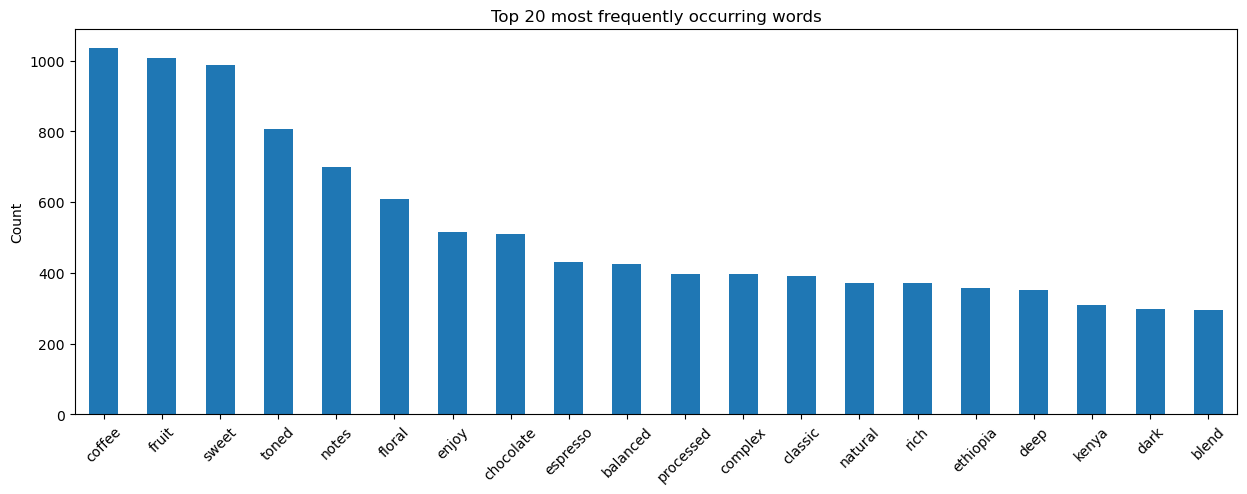

In [250]:
# 1. Instantiate 
bagofwords_p3 = CountVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
bagofwords_p3.fit(X_remain["p3"])

# 3. Transform
p3_remain_transform = bagofwords_p3.transform(X_remain["p3"])
p3_val_transform = bagofwords_p3.transform(X_val["p3"])
p3_test_transform = bagofwords_p3.transform(X_test["p3"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": p3_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p3.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [251]:
bagofwords_p3.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['accessible',
 'acid',
 'acidity',
 'acidy',
 'adventurers',
 'aficionados',
 'africa',
 'america',
 'american',
 'anaerobic',
 'animated',
 'appeal',
 'appealing',
 'appreciate',
 'arabica',
 'aroma',
 'aromatic',
 'aromatically',
 'aromatics',
 'assertive',
 'associated',
 'attractive',
 'austere',
 'authoritative',
 'authority',
 'avoid',
 'avoiders',
 'baking',
 'balance',
 'balanced',
 'ballast',
 'beans',
 'berry',
 'best',
 'better',
 'beverages',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blend',
 'blends',
 'blue',
 'bodied',
 'body',
 'bold',
 'bomb',
 'bourbon',
 'bracing',
 'brandy',
 'brazil',
 'breakfast',
 'brew',
 'brewed',
 'bright',
 'brightly',
 'brightness',
 'bring',
 'brisk',
 'briskly',
 'burned',
 'burundi',
 'cacao',
 'caffeine',
 'cappuccino',
 'caramel',
 'caramelly',
 'carry',
 'case',
 'cedar',
 'celebrated',
 'centered',
 'central',
 'certified',
 'character',
 'characteristic',
 'characterized',
 'chocolate',
 'chocolaty',
 'ch

In [252]:
len(bagofwords_p3.get_feature_names())

500

In [253]:
# 1. Instantiate the model
p3_model = LinearRegression()

# 2. Fit the model
p3_model.fit(p3_remain_transform, y_remain)

LinearRegression()

In [254]:
# 3. Scoring the training model
print(f'The R2 score for p3 CountVectorizor training data is: {p3_model.score(p3_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p3 CountVectorizor validation data is: {p3_model.score(p3_val_transform, y_val)}')

The R2 score for p3 CountVectorizor training data is: 0.554015769509018
The R2 score for p3 CountVectorizor validation data is: 0.47637291386813474


### Bag of Words with TFIDF

`p1` Tokenizing first paragraph with TFIDF and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


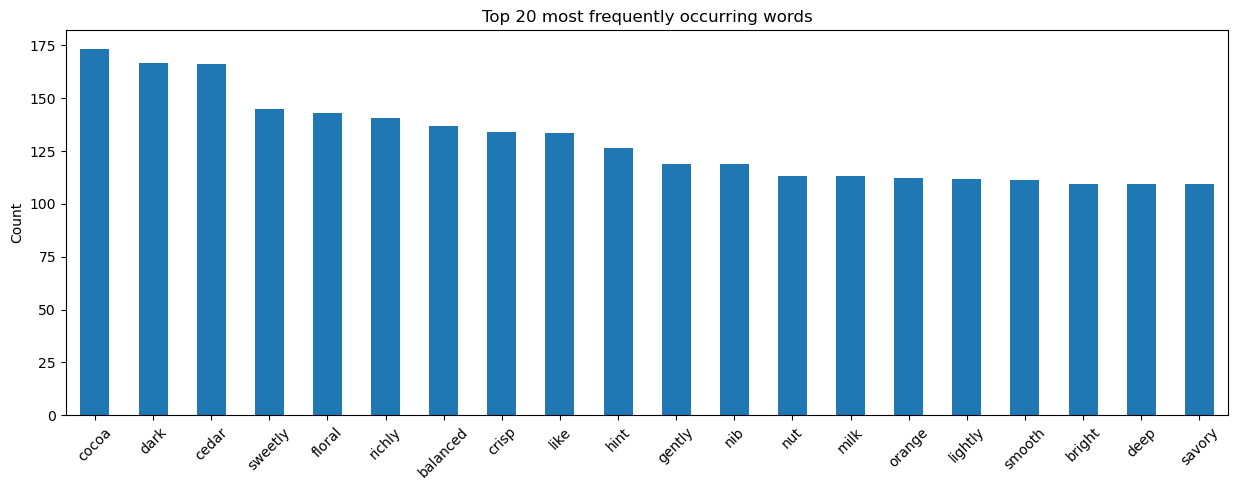

In [255]:
# 1. Instantiate 
tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p1.fit(X_remain["p1"])

# 3. Transform
tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
tp1_val_transform = tfidf_p1.transform(X_val["p1"])
tp1_test_transform = tfidf_p1.transform(X_test["p1"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp1_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p1.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [256]:
tfidf_p1.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['89',
 '90',
 '91',
 '92',
 'acid',
 'acidy',
 'admired',
 'aftertaste',
 'agave',
 'almond',
 'amber',
 'amplified',
 'anise',
 'apple',
 'apricot',
 'aromatic',
 'aromatically',
 'aromatics',
 'astringency',
 'astringent',
 'attractive',
 'authority',
 'b70',
 'backgrounded',
 'baker',
 'baking',
 'balance',
 'balanced',
 'banana',
 'barrel',
 'bean',
 'bergamot',
 'berries',
 'berry',
 'best',
 'big',
 'bing',
 'bit',
 'bitter',
 'bitterish',
 'bitterness',
 'bittersweet',
 'black',
 'blackberry',
 'blend',
 'blood',
 'blooming',
 'blossom',
 'blueberry',
 'bodied',
 'body',
 'brandy',
 'brazil',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brisk',
 'brittle',
 'brown',
 'buoyant',
 'burned',
 'butter',
 'butterscotch',
 'buttery',
 'cacao',
 'called',
 'candied',
 'candy',
 'cane',
 'cappuccino',
 'capsule',
 'caramel',
 'caramelly',
 'carbon',
 'cardamom',
 'carob',
 'carries',
 'carry',
 'carrying',
 'cashew',
 'cedar',
 'cedary',
 'centered',
 'centers',
 'character',
 'cha

In [257]:
len(tfidf_p1.get_feature_names())

500

In [258]:
# 1. Instantiate the model
tp1_model = LinearRegression()

# 2. Fit the model
tp1_model.fit(tp1_remain_transform, y_remain)

LinearRegression()

In [259]:
# 3. Scoring the training model
print(f'The R2 score for p1 with TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p1 with TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

The R2 score for p1 with TFIDF training data is: 0.8051231259920271
The R2 score for p1 with TFIDF validation data is: 0.7490196321789198


Tokenizing second paragraph with TFIDF:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


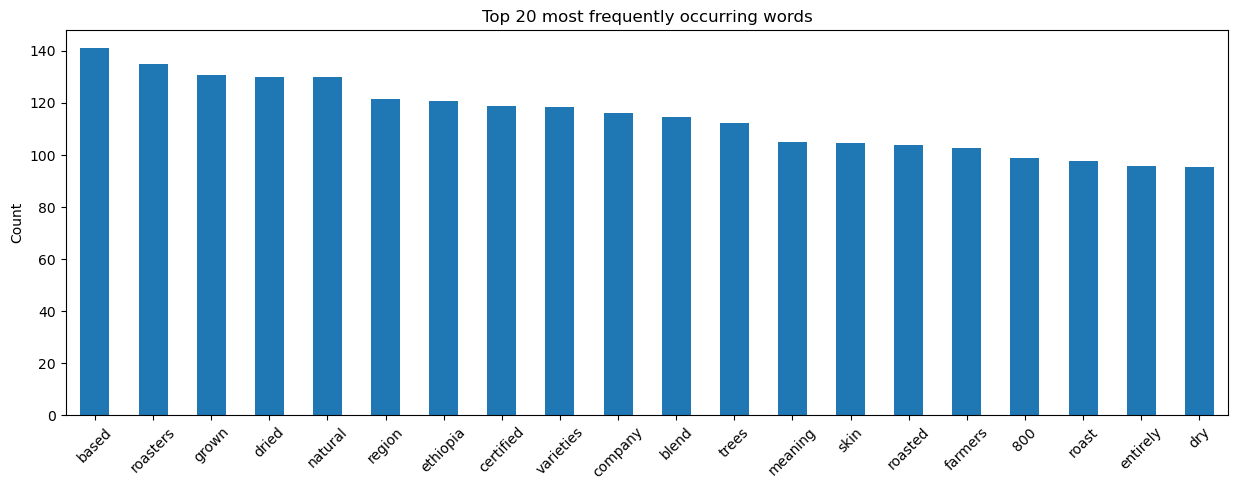

In [260]:
# 1. Instantiate 
tfidf_p2 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p2.fit(X_remain["p2"])

# 3. Transform
tp2_remain_transform = tfidf_p2.transform(X_remain["p2"])
tp2_val_transform = tfidf_p2.transform(X_val["p2"])
tp2_test_transform = tfidf_p2.transform(X_test["p2"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp2_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p2.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [261]:
tfidf_p2.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '0626',
 '100',
 '1282',
 '1990',
 '2005',
 '2010',
 '2012',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '256',
 '28',
 '30',
 '433',
 '454',
 '4627',
 '5282',
 '608',
 '678',
 '763',
 '800',
 '858',
 '866',
 '877',
 '886',
 '888',
 '916',
 'aa',
 'acidity',
 'active',
 'addition',
 'admired',
 'africa',
 'agricultural',
 'air',
 'alliance',
 'allowed',
 'america',
 'american',
 'anaerobic',
 'angeles',
 'appear',
 'approach',
 'area',
 'aroma',
 'aromatic',
 'artisan',
 'asia',
 'associated',
 'auction',
 'available',
 'award',
 'awarded',
 'bag',
 'barista',
 'based',
 'batch',
 'batches',
 'bay',
 'bean',
 'beaned',
 'best',
 'better',
 'big',
 'bird',
 'black',
 'blend',
 'blends',
 'blue',
 'bold',
 'botanical',
 'bourbon',
 'boutique',
 'brand',
 'brazil',
 'brew',
 'brewing',
 'bring',
 'brothers',
 'burundi',
 'business',
 'cafe',
 'café',
 'california',
 'called',
 'capsule',
 'case',
 'catuai',
 'caturra',
 'celebrated',
 'central',
 'certified',
 'chain',
 'charac

In [262]:
len(tfidf_p2.get_feature_names())

500

In [263]:
# 1. Instantiate the model
tp2_model = LinearRegression()

# 2. Fit the model
tp2_model.fit(tp2_remain_transform, y_remain)

LinearRegression()

In [264]:
# 3. Scoring the training model
print(f'The R2 score for p2 TFIDF training data is: {tp2_model.score(tp2_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p2 TFIDF validation data is: {tp2_model.score(tp2_val_transform, y_val)}')

The R2 score for p2 TFIDF training data is: 0.7114301659456762
The R2 score for p2 TFIDF validation data is: 0.6491965283647982


Tokenizing 3rd paragraph with TFIDF:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


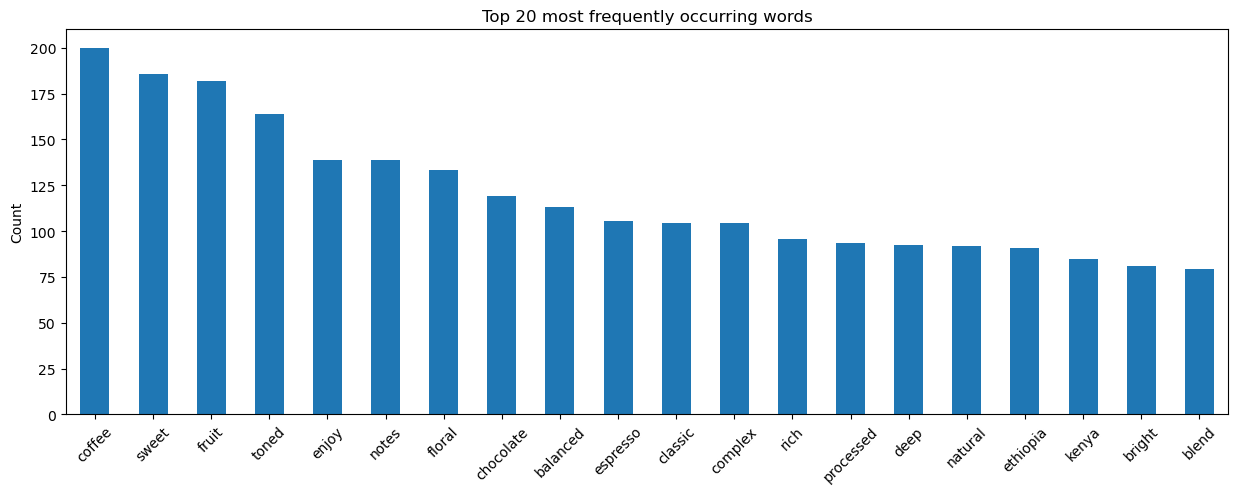

In [265]:
# 1. Instantiate 
tfidf_p3 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p3.fit(X_remain["p3"])

# 3. Transform
tp3_remain_transform = tfidf_p3.transform(X_remain["p3"])
tp3_val_transform = tfidf_p3.transform(X_val["p3"])
tp3_test_transform = tfidf_p3.transform(X_test["p3"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp3_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p3.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [266]:
tfidf_p3.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['accessible',
 'acid',
 'acidity',
 'acidy',
 'adventurers',
 'aficionados',
 'africa',
 'america',
 'american',
 'anaerobic',
 'animated',
 'appeal',
 'appealing',
 'appreciate',
 'arabica',
 'aroma',
 'aromatic',
 'aromatically',
 'aromatics',
 'assertive',
 'associated',
 'attractive',
 'austere',
 'authoritative',
 'authority',
 'avoid',
 'avoiders',
 'baking',
 'balance',
 'balanced',
 'ballast',
 'beans',
 'berry',
 'best',
 'better',
 'beverages',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blend',
 'blends',
 'blue',
 'bodied',
 'body',
 'bold',
 'bomb',
 'bourbon',
 'bracing',
 'brandy',
 'brazil',
 'breakfast',
 'brew',
 'brewed',
 'bright',
 'brightly',
 'brightness',
 'bring',
 'brisk',
 'briskly',
 'burned',
 'burundi',
 'cacao',
 'caffeine',
 'cappuccino',
 'caramel',
 'caramelly',
 'carry',
 'case',
 'cedar',
 'celebrated',
 'centered',
 'central',
 'certified',
 'character',
 'characteristic',
 'characterized',
 'chocolate',
 'chocolaty',
 'ch

In [267]:
len(tfidf_p3.get_feature_names())

500

In [268]:
# 1. Instantiate the model
tp3_model = LinearRegression()

# 2. Fit the model
tp3_model.fit(tp3_remain_transform, y_remain)

LinearRegression()

In [269]:
# 3. Scoring the training model
print(f'The R2 score for p3 TFIDF training data is: {tp3_model.score(tp3_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p3 TFIDF validation data is: {tp3_model.score(tp3_val_transform, y_val)}')

The R2 score for p3 TFIDF training data is: 0.6053616878209478
The R2 score for p3 TFIDF validation data is: 0.5087475066564686


Comparing scores:

### Exploring different ranges for  vectorizing values

IMPORTANT: For now, just exploring these one piece at time to get sense of how well these vectorizers can perform. Later, need to fine-tune considering how changes interact with each other.

Exploring impact of changing min_df:

In [270]:
for i in range(1,30,2):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=i, max_features=500, max_df=2000)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'min_df: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

min_df: 1
The R2 score for p1 CountVectorizer training data is: 0.7896872142538632
The R2 score for p1 CountVectorizer validation data is: 0.7388571303242173
min_df: 3
The R2 score for p1 CountVectorizer training data is: 0.7894498773691305
The R2 score for p1 CountVectorizer validation data is: 0.7391382599938092
min_df: 5
The R2 score for p1 CountVectorizer training data is: 0.7897119456582152
The R2 score for p1 CountVectorizer validation data is: 0.7390051641796078
min_df: 7
The R2 score for p1 CountVectorizer training data is: 0.7905174062541752
The R2 score for p1 CountVectorizer validation data is: 0.7403615042900409
min_df: 9
The R2 score for p1 CountVectorizer training data is: 0.7902886819579508
The R2 score for p1 CountVectorizer validation data is: 0.7410289889291571
min_df: 11
The R2 score for p1 CountVectorizer training data is: 0.7897804193777154
The R2 score for p1 CountVectorizer validation data is: 0.7382447403965214
min_df: 13
The R2 score for p1 CountVectorizer trai

Min_df at 7-9 or 17 looks best.

Experimenting with best max_feature range:

In [279]:
for i in range(100,1000,50):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=i, max_df=2000)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'max_features: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

max_features: 100
The R2 score for p1 CountVectorizer training data is: 0.5797747684160732
The R2 score for p1 CountVectorizer validation data is: 0.5733883710839496
max_features: 150
The R2 score for p1 CountVectorizer training data is: 0.6176951945214121
The R2 score for p1 CountVectorizer validation data is: 0.6072352085868395
max_features: 200
The R2 score for p1 CountVectorizer training data is: 0.6508944690746765
The R2 score for p1 CountVectorizer validation data is: 0.6221950762983852
max_features: 250
The R2 score for p1 CountVectorizer training data is: 0.6724997726483191
The R2 score for p1 CountVectorizer validation data is: 0.6341248708468861
max_features: 300
The R2 score for p1 CountVectorizer training data is: 0.7086634672380812
The R2 score for p1 CountVectorizer validation data is: 0.6625109055115557
max_features: 350
The R2 score for p1 CountVectorizer training data is: 0.7339411520115722
The R2 score for p1 CountVectorizer validation data is: 0.7015464115673085
max_

Modifying the number of `max_features` seems to matter a lot for validation data. Best number appears to be around 500 for best validation score.

In [280]:
for i in range(100,20000,1000):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=i)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'max_df: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

max_df: 100
The R2 score for p1 CountVectorizer training data is: 0.7093773948672423
The R2 score for p1 CountVectorizer validation data is: 0.5908613408452319
max_df: 1100
The R2 score for p1 CountVectorizer training data is: 0.7789278000048976
The R2 score for p1 CountVectorizer validation data is: 0.7249320513679023
max_df: 2100
The R2 score for p1 CountVectorizer training data is: 0.7905174062541752
The R2 score for p1 CountVectorizer validation data is: 0.7403615042900409
max_df: 3100
The R2 score for p1 CountVectorizer training data is: 0.7943475929965591
The R2 score for p1 CountVectorizer validation data is: 0.7500581626565016
max_df: 4100
The R2 score for p1 CountVectorizer training data is: 0.8008811711459416
The R2 score for p1 CountVectorizer validation data is: 0.7542489517777461
max_df: 5100
The R2 score for p1 CountVectorizer training data is: 0.8008811711459416
The R2 score for p1 CountVectorizer validation data is: 0.7542489517777461
max_df: 6100
The R2 score for p1 Co

Max_df appears to best around 3100 and after that stops improving.

Testing with these parameters:

In [281]:
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=3100)

bagofwords_p1.fit(X_remain["p1"])

p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

p1_model = LinearRegression()

p1_model.fit(p1_remain_transform, y_remain)

print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.7943475929965591
The R2 score for p1 CountVectorizer validation data is: 0.7500581626565016


Doing similar thing with TFIDF:

In [282]:
for i in range(1,30,2):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=i, max_df=1000, max_features=500)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'min_df value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

min_df value: 1
The R2 score for p3 TFIDF training data is: 0.8042834456022296
The R2 score for p3 TFIDF validation data is: 0.7509866585153195
min_df value: 3
The R2 score for p3 TFIDF training data is: 0.803825200599879
The R2 score for p3 TFIDF validation data is: 0.750603545325333
min_df value: 5
The R2 score for p3 TFIDF training data is: 0.8051231259920271
The R2 score for p3 TFIDF validation data is: 0.7490196321789198
min_df value: 7
The R2 score for p3 TFIDF training data is: 0.8040220418674355
The R2 score for p3 TFIDF validation data is: 0.7510907721078269
min_df value: 9
The R2 score for p3 TFIDF training data is: 0.8052760278496993
The R2 score for p3 TFIDF validation data is: 0.7501419525597618
min_df value: 11
The R2 score for p3 TFIDF training data is: 0.8037732636187147
The R2 score for p3 TFIDF validation data is: 0.7507773361051449
min_df value: 13
The R2 score for p3 TFIDF training data is: 0.8044153217932147
The R2 score for p3 TFIDF validation data is: 0.751338557

This one also seems to do better with lower min_df value, peaking around 7 (although there's not a huge difference at lower scores).

Experimenting with max_features:

In [283]:
for i in range(1,1000,100):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=i, max_df=1000)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'max_features value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

max_features value: 1
The R2 score for p3 TFIDF training data is: 0.002335886590347558
The R2 score for p3 TFIDF validation data is: 0.003243920138420231
max_features value: 101
The R2 score for p3 TFIDF training data is: 0.6084897903576443
The R2 score for p3 TFIDF validation data is: 0.6157139716199187
max_features value: 201
The R2 score for p3 TFIDF training data is: 0.6768866248194411
The R2 score for p3 TFIDF validation data is: 0.6481379268542131
max_features value: 301
The R2 score for p3 TFIDF training data is: 0.7272538487712925
The R2 score for p3 TFIDF validation data is: 0.687074174636589
max_features value: 401
The R2 score for p3 TFIDF training data is: 0.7808974142400383
The R2 score for p3 TFIDF validation data is: 0.7424839587562565
max_features value: 501
The R2 score for p3 TFIDF training data is: 0.8041750833011452
The R2 score for p3 TFIDF validation data is: 0.7515392349854042
max_features value: 601
The R2 score for p3 TFIDF training data is: 0.8293742842446599


This one also seems to peak around 500.

Exploring max_df:

In [284]:
for i in range(1000,10000,500):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=500, max_df=i)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'max_df value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

max_df value: 1000
The R2 score for p3 TFIDF training data is: 0.8040220418674355
The R2 score for p3 TFIDF validation data is: 0.7510907721078269
max_df value: 1500
The R2 score for p3 TFIDF training data is: 0.8163416506437414
The R2 score for p3 TFIDF validation data is: 0.7637502659317814
max_df value: 2000
The R2 score for p3 TFIDF training data is: 0.816110874402247
The R2 score for p3 TFIDF validation data is: 0.7642689211868305
max_df value: 2500
The R2 score for p3 TFIDF training data is: 0.8175346263245817
The R2 score for p3 TFIDF validation data is: 0.7661300975420998
max_df value: 3000
The R2 score for p3 TFIDF training data is: 0.8191362248053908
The R2 score for p3 TFIDF validation data is: 0.7681667480032249
max_df value: 3500
The R2 score for p3 TFIDF training data is: 0.8197208196048785
The R2 score for p3 TFIDF validation data is: 0.7683801288959564
max_df value: 4000
The R2 score for p3 TFIDF training data is: 0.8224350866339608
The R2 score for p3 TFIDF validation 

This one seems to peak around 4000.

### Comparing best versions:

CountVectorizor():

In [285]:
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=3100)

bagofwords_p1.fit(X_remain["p1"])

p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

p1_model = LinearRegression()

p1_model.fit(p1_remain_transform, y_remain)

print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.8008811711459416
The R2 score for p1 CountVectorizer validation data is: 0.7542489517777461


In [286]:
tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=500, max_df=4000)

tfidf_p1.fit(X_remain["p1"])

tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
tp1_val_transform = tfidf_p1.transform(X_val["p1"])
tp1_test_transform = tfidf_p1.transform(X_test["p1"])

tp1_model = LinearRegression()

tp1_model.fit(tp1_remain_transform, y_remain)

print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

The R2 score for p3 TFIDF training data is: 0.8224350866339608
The R2 score for p3 TFIDF validation data is: 0.769545820812519


Between the two, the TfidfVectorizer() does slightly better on these initial test runs, although it is also more overfit that the CountVectorizer().

### Word Embedding: